# Assessment 3: RNNs for stock price prediction

In [209]:
import sys, site
from pathlib import Path

################################# NOTE #################################
#  Please be aware that if colab installs the latest numpy and pyqlib  #
#  in this cell, users should RESTART the runtime in order to run the  #
#  following cells successfully.                                       #
########################################################################

try:
    import qlib
except ImportError:
    # install qlib
    ! pip install --upgrade numpy
    ! pip install pyqlib
    if "google.colab" in sys.modules:
        # The Google colab environment is a little outdated. We have to downgrade the pyyaml to make it compatible with other packages
        ! pip install pyyaml==5.4.1
    # reload
    site.main()

scripts_dir = Path.cwd().parent.joinpath("scripts")
if not scripts_dir.joinpath("get_data.py").exists():
    # download get_data.py script
    scripts_dir = Path("~/tmp/qlib_code/scripts").expanduser().resolve()
    scripts_dir.mkdir(parents=True, exist_ok=True)
    import requests

    with requests.get("https://raw.githubusercontent.com/microsoft/qlib/main/scripts/get_data.py", timeout=10) as resp:
        with open(scripts_dir.joinpath("get_data.py"), "wb") as fp:
            fp.write(resp.content)

In [210]:
## Dataset
import qlib
from qlib.constant import REG_US
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
## Data manioulation
import pandas as pd
import numpy as np
import datetime as dt
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## pytorch part
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [211]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Set the seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


Using device: cpu



## Step01: Data exploration

In [212]:
# use default data
# NOTE: need to download data from remote: python scripts/get_data.py qlib_data_cn --target_dir ~/.qlib/qlib_data/cn_data
# from qlib.config import REG_US
provider_uri = "~/.qlib/qlib_data/us_data"  # target_dir
if not exists_qlib_data(provider_uri):
    print(f"Qlib data is not found in {provider_uri}")
    sys.path.append(str(scripts_dir))
    from get_data import GetData

    GetData().qlib_data(target_dir=provider_uri, region=REG_US)
qlib.init(provider_uri=provider_uri, region=REG_US)

[17808:MainThread](2023-11-18 00:24:50,339) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[17808:MainThread](2023-11-18 00:24:50,343) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[17808:MainThread](2023-11-18 00:24:50,344) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/possa/.qlib/qlib_data/us_data')}


In [213]:
from qlib.data import D
# parameter selection
# index_list  = ['^GSPC','^IXIC','^DJI']
# index_list  = ['AAPL', 'MSFT']
# index_name  = ['Apple', 'Microsoft']
# index_list  = ['AAPL']
# index_name  = ['Apple']
# fields = ['$close', '$volume', '$open', '$high', '$low']

# df = D.features(D.instruments("all"), ["$close"], freq="day")
# inst = D.list_instruments(D.instruments(symbols ), freq="day", as_list=True) # show the selecting symbols 

# Fetch daily data for the indices
def set_df():
    # select the index & Fleids
    index_list  = ['AAPL']
    # index_list  = ['AAPL', 'MSFT']
    # fields = ['$close', '$volume', '$open', '$high', '$low']
    fields = ['$close']
    # download dataset
    df = D.features(index_list , fields, freq='day')
    
    # manipulated the dataset
    df = df.reset_index()
    # df.columns = ['symbols','date','close','volume','open','high','low']
    df.columns = ['symbols','date','close']
    df = df.drop(columns='symbols')
    df.date = df.date.dt.date
    print(f"Period since {min(df.date)} to {max(df.date)}: {max(df.date) - min(df.date)}")
    df = df.set_index(['date'])
    df.index = pd.to_datetime(df.index)
    if not df.index.is_monotonic:
        df = df.sort_index()
    df = df.rename(columns={'close': 'value'})
    return df, index_list

df, index_list = set_df()

Period since 1999-12-31 to 2020-11-10: 7620 days, 0:00:00


In [214]:
df.tail(5)

,value
date,
2020-11-04,146.096085
2020-11-05,151.281586
2020-11-06,151.109711
2020-11-09,148.092346
2020-11-10,147.646759


### Exploratory Image analysis

In [215]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

In [216]:
plot_dataset(df, title='title please added')

In [246]:
# features: lagging
def generate_time_lags(df, period):
    df_n = df.copy()
    # for n in range(1, n_lags + 1):
    for n in period:
        df_n[f"lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[max(period):]
    return df_n

# features: encode the day features
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def onehot_encode(df, onehot_columns):
    ct = ColumnTransformer(
        [('onehot', OneHotEncoder(drop='first'), onehot_columns)],
        remainder='passthrough'
        )
    return ct.fit_transform(df)


def onehot_encode_pd(df, col_name):
    dummies = pd.get_dummies(df[col_name], prefix=col_name)
    return pd.concat([df, dummies], axis=1).drop(columns=[col_name])

# features: holidays
from datetime import date
import holidays



def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in us_holidays) else 0

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))

# combine feature
def add_feature(df):
    df = (
                df
                .assign(hour = df.index.hour)
                .assign(day = df.index.day)
                .assign(month = df.index.month)
                .assign(day_of_week = df.index.dayofweek)
                .assign(week_of_year = df.index.week)
              )
    df = generate_time_lags(df, [7,14,30,60])
    us_holidays = holidays.US()
    df = add_holiday_col(df, us_holidays)
    # onehot_columns = ['month','day','day_of_week','week_of_year']
    # df = onehot_encode(df, onehot_columns)
    # df_feature = onehot_encode_pd(df, onehot_columns)
    return df

df_feature = add_feature(df)
print(df_feature.head(3))

               value  hour  day  month  day_of_week  week_of_year      lag7  \
date                                                                          
2000-03-28  1.353191     0   28      3            1            13  1.215805   
2000-03-29  1.322188     0   29      3            2            13  1.196352   
2000-03-30  1.223101     0   30      3            3            13  1.312462   

               lag14     lag30     lag60  is_holiday  
date                                                  
2000-03-28  1.186626  1.126444  1.000000           0  
2000-03-29  1.189057  1.157446  1.088754           0  
2000-03-30  1.223101  1.110030  0.996960           0  


c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\ipykernel_launcher.py:47: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



## Step 03: Data splitting

In [218]:
# splitting criteria training 70%, validation 20% and testing 10%

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def split_data(df, target_col):
    train_size = int(len(df) * 0.7)
    valid_size = int(len(df) * 0.2)
    
    # split for train / valid / test
    train_data = df[:train_size]
    valid_data = df[train_size:train_size + valid_size]
    test_data = df[train_size + valid_size:]
    
    print(f"Training size: {len(train_data)} period {train_data.index[0]} to {train_data.index[len(train_data)-1]} \nValidation size: {len(valid_data)} period {valid_data.index[0]} to {valid_data.index[len(valid_data)-1]}\ntest_data size: {len(test_data)} period {test_data.index[0]} to {test_data.index[len(test_data)-1]}")
    
    x_train, y_train = feature_label_split(train_data, target_col)
    x_valid, y_valid = feature_label_split(valid_data, target_col)
    x_test, y_test = feature_label_split(test_data, target_col)
    
    # return train_data,valid_data, test_data
    return x_train, y_train, x_valid, y_valid, x_test, y_test
    
    
# train_size = int(len(df) * 0.7)
# valid_size = int(len(df) * 0.2)

# train_data = df[:train_size]
# valid_data = df[train_size:train_size + valid_size]
# test_data = df[train_size + valid_size:]

# print(f"Training size: {len(train_data)} period {train_data.index[0]} to {train_data.index[len(train_data)-1]} \nValidation size: {len(valid_data)} period {valid_data.index[0]} to {valid_data.index[len(valid_data)-1]}\ntest_data size: {len(test_data)} period {test_data.index[0]} to {test_data.index[len(test_data)-1]}")

X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_feature, 'value')

X_train

Training size: 3632 period 2000-03-28 00:00:00 to 2014-09-04 00:00:00 
Validation size: 1038 period 2014-09-05 00:00:00 to 2018-10-17 00:00:00
test_data size: 520 period 2018-10-18 00:00:00 to 2020-11-10 00:00:00


,hour,day,month,day_of_week,week_of_year,lag7,lag14,lag30,lag60,is_holiday
date,,,,,,,,,,
2000-03-28,0,28,3,1,13,1.215805,1.186626,1.126444,1.000000,0
2000-03-29,0,29,3,2,13,1.196352,1.189057,1.157446,1.088754,0
2000-03-30,0,30,3,3,13,1.312462,1.223101,1.110030,0.996960,0
2000-03-31,0,31,3,4,13,1.402432,1.179939,1.117325,1.011550,0
2000-04-03,0,3,4,0,14,1.374468,1.111246,1.082067,0.924012,0
...,...,...,...,...,...,...,...,...,...,...
2014-08-28,0,28,8,3,35,28.786461,27.128508,26.524109,26.246912,0
2014-08-29,0,29,8,4,35,28.797913,27.486439,26.905909,26.349895,0
2014-09-02,0,2,9,1,36,28.800777,27.480719,26.766296,26.277433,0


## Step 3: Data Preprocessing

In [219]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
 
X_train, y_train, X_val, y_val, X_test, y_test    
    
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [220]:
def create_dataset(dataset,time_step):
    X,y = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:i+time_step,0]
        X.append(a)
        y.append(dataset[i+time_step,0])
        
    # #RNN and LSTM takes 3D inputs, we need to change the shape of array to 3 dimensional.
    X_output = torch.tensor(np.array(X))
    X_output = X_output.reshape(X_output.shape[0],X_output.shape[1],1)
    Y_output = torch.tensor(np.array(y)).unsqueeze(dim=1)
    # return X_output,Y_output
    return torch.utils.data.TensorDataset(X_output, Y_output)

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

batch_size = 1
trainloader = torch.utils.data.DataLoader(
    # torch.utils.data.TensorDataset(X_train, y_train), 
    TensorDataset(train_features, train_targets),
    shuffle=True, 
    batch_size=batch_size,
    pin_memory = True
    )
valloader = torch.utils.data.DataLoader(
    TensorDataset(val_features, val_targets),
    batch_size=batch_size,
    shuffle=False,
    # num_workers=worker,
    pin_memory = True
    )
testloader = torch.utils.data.DataLoader(
    # create_dataset(test_data,20),
    TensorDataset(test_features, test_targets),
    batch_size=batch_size,
    shuffle=False,
    pin_memory = True
    )


## Step 04: Define the RNN Model

In [221]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()

        self.RNN = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.RNN(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state
rnn = RNN(input_size = 1, hidden_size = 32, num_layers = 2,  output_size = 1)
rnn    

RNN(
  (RNN): RNN(1, 32, num_layers=2)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

### Vanilla RNN

In [222]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

### Long Short-Term Memory (LSTM)

In [223]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

### Gated Recurrent Unit (GRU)

In [224]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [225]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

## Step 05: training model

In [226]:
import time
from tqdm import tqdm

## apply the dataloader
set_seed(1311)

def train_epoch(model, dataloader, criterion, optimizer, n_features = 1):
    model.train()
    
    # Initializing variable
    running_loss = 0.0
    # correct_train = 0
    total_train = 0
    hidden = None
    
    for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs, labels = inputs.view([batch_size, -1, n_features]).to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        # hidden = hidden.data
        
        loss = criterion(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        # _, preds = torch.max(outputs, 1)
        # correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)
        
    epoch_loss = running_loss / total_train
    # epoch_acc = correct_train.double() / total_train
    return epoch_loss #, epoch_acc
    
def evaluate(model, dataloader, criterion, n_features = 1):
    model.eval()
    running_loss = 0.0
    # correct = 0
    total = 0
    # hidden = None
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs, labels = inputs.view([batch_size, -1, n_features]).to(device), labels.to(device)
            outputs = model(inputs)
            # hidden = hidden.data
            
            # loss = criterion(outputs, labels)
            loss = criterion(outputs.view(-1), labels)
            running_loss += loss.item() * inputs.size(0)
            # _, preds = torch.max(outputs, 1)
            # correct += torch.sum(preds == labels.data)
            total += labels.size(0)
    
    loss = running_loss / total
    # accuracy = correct.double() / total

    # results = (loss, accuracy)
    return loss

def train_network(model, optimizer, criterion, scheduler, trainloader, valloader, testloader, num_epochs, input_dim, model_name, dataset):

    ## section00: setting path for save the model
    set_seed(1311)
    PATH = f'./model/{dataset}_{model_name}.pth'
    print('Model will be saved to:', PATH)
    print('Using device:', device, 'with seed: 1311')
    print()

    ## section01: Initialize variables
    best_val_loss = 100000  # to track the best validation accuracy
    # create set to collect the output
    history = {
        'train_loss': [],
        'val_loss': [],
    }
    
     ## section02: Training and validation the model
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        train_loss = train_epoch(model, trainloader, criterion, optimizer,input_dim)
        val_loss = evaluate(model, valloader, criterion, input_dim)

        # Step the scheduler with the validation loss
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        # history['train_accuracy'].append(100 * train_acc)
        history['val_loss'].append(val_loss)
        # history['val_accuracy'].append(100 * val_acc)
        
        # Save the model if it has improved on validation accuracy
        if best_val_loss > val_loss:
            print("check loss: ",best_val_loss,val_loss)
            best_val_loss = val_loss
            torch.save(model.state_dict(), PATH)
            print(f'Model improved and saved to {PATH}')
            
        # print epoch results
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')
        
    print('Training complete. Evaluating on test set with the best model...')
    
    ## section03: Load the best model for final evaluation on test set
    best_model = model
    best_model.load_state_dict(torch.load(PATH))
    
    test_loss = evaluate(best_model, testloader, criterion, input_dim)
    # y_pred, h_State = best_model(torch.tensor(test_data))
    print(f'Test Loss: {test_loss:.4f}')
    # Add test results to history
    history['test_loss'] = test_loss
    history['best_model'] = best_model
    
    return history

In [227]:
def plot_loss(train_loss, val_loss):
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().numpy() for x in train_loss]
    if isinstance(val_loss[0], torch.Tensor):
        val_loss = [x.cpu().numpy() for x in val_loss]

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()


In [228]:
# from torchsummary import summary
# for i in [rnn]:
#     print("Model: ", i.__class__.__name__)
#     print("Number of parameters: ", sum(p.numel() for p in i.parameters() if p.requires_grad))
#     # summary(i.to(device), (3, 32, 32))
#     print("-"*50)

In [229]:
len(X_train.columns)

10

Model will be saved to: ./model/AAPL_lstm.pth
Using device: cpu with seed: 1311



Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1585.06it/s]


check loss:  100000 1.6317507737748655
Model improved and saved to ./model/AAPL_lstm.pth
Epoch 1/2, Train Loss: 0.1137, Val Loss: 1.6318, Time: 15.26s


Evaluating: 100%|██████████| 1038/1038 [00:00<00:00, 1693.19it/s]


check loss:  1.6317507737748655 1.1889525191689732
Model improved and saved to ./model/AAPL_lstm.pth
Epoch 2/2, Train Loss: 0.0693, Val Loss: 1.1890, Time: 14.82s
Training complete. Evaluating on test set with the best model...


Evaluating: 100%|██████████| 520/520 [00:00<00:00, 1405.30it/s]


Test Loss: 6.9841


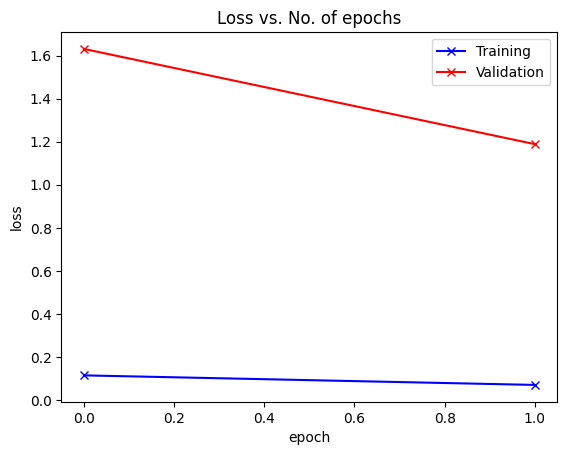

In [232]:
# Set up the model structure
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
dropout = 0.2
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

# Set up the training hyperparameter
num_epochs = 2
learning_rate = 1e-5
weight_decay = 1e-4

model_name = 'lstm'
model = get_model(model_name, model_params)
model

dataset = index_list[0]

# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.001)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)


rnn_results = train_network(model,
                            optimizer,
                            criterion,
                            scheduler,
                            trainloader,
                            valloader,
                            testloader,
                            num_epochs,
                            input_dim,
                            model_name,
                            dataset
                            )
plot_loss(rnn_results['train_loss'], rnn_results['val_loss'])

### 6. Evaluation with Testing Set

In [234]:
df

,value
date,
1999-12-31,1.000000
2000-01-03,1.088754
2000-01-04,0.996960
2000-01-05,1.011550
2000-01-06,0.924012
...,...
2020-11-04,146.096085
2020-11-05,151.281586
2020-11-06,151.109711


In [247]:
model_pred = rnn_results['best_model']


df_feature = add_feature(df)
df_feature

c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\ipykernel_launcher.py:47: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



,value,hour,day,month,day_of_week,week_of_year,lag7,lag14,lag30,lag60,is_holiday
date,,,,,,,,,,,
2000-03-28,1.353191,0,28,3,1,13,1.215805,1.186626,1.126444,1.000000,0
2000-03-29,1.322188,0,29,3,2,13,1.196352,1.189057,1.157446,1.088754,0
2000-03-30,1.223101,0,30,3,3,13,1.312462,1.223101,1.110030,0.996960,0
2000-03-31,1.320972,0,31,3,4,13,1.402432,1.179939,1.117325,1.011550,0
2000-04-03,1.296656,0,3,4,0,14,1.374468,1.111246,1.082067,0.924012,0
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-04,146.096085,0,4,11,2,45,146.223190,153.416779,136.144516,139.010513,0
2020-11-05,151.281586,0,5,11,3,45,148.193161,151.268860,137.542572,143.630447,0
2020-11-06,151.109711,0,6,11,4,45,141.330002,147.405167,142.702652,146.172348,0


In [254]:
# train_data
# valid_data
# test_data
# train_df
# valid_df
# test_df
model_pred = rnn_results['best_model']
# Assuming df_feature is a pandas DataFrame
# Convert DataFrame to numpy array, then to a tensor
df_feature_array = df_feature.values
df_feature_tensor = torch.tensor(df_feature_array, dtype=torch.float32)  # Ensure the data type is correct

# Reshape the tensor to match the model's input shape
# Adjust the shape according to your model's requirements
predict_Data = df_feature_tensor.reshape([batch_size, -1, 10]).to(device)

# Predict using the model
outputs = model_pred(predict_Data)

# Move outputs to CPU and convert to numpy if necessary
outputs_numpy = outputs.detach().cpu().numpy()
outputs
# Ensure plot_loss function is compatible with the arguments
# plot_loss(outputs_numpy, df_feature)  # This line might need modification

tensor([[2.2397]], grad_fn=<AddmmBackward0>)